# Improving Siamese Network Using Gabor Filter

## Siamese Network
In recent years, convolutional neural networks (CNNs) are almost good at every task, but these CNNs rely on more data to perform well. But for particular problems, we can’t always rely on getting more data, to solve this kind of tasks we have a new type of the CNN architecture called Siamese Networks. It uses only a few numbers of images to get better predictions. The ability to learn from very small data made Siamese networks more popular in nowadays.

Figure 1 : An architecture of Siamese Network
![An architecture of Siamese Network](https://raw.githubusercontent.com/rauzansumara/siamese-network-with-gabor-filter/master/images/Capture3.PNG "An architecture of Siamese Network") 

*Source:* [http://datahacker.rs](http://datahacker.rs/one-shot-learning-with-siamese-neural-network/)

A Siamese Neural Network is a class of neural network architectures that contain two identical subnetworks. **identical** here means, they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub-networks. It is used to find the similarity of the inputs by comparing its feature vectors, so these networks are used in many applications. Traditionally, a neural network learns to predict multiple classes. This poses a problem when we need to add/remove new classes to the data. In this case, we have to update the neural network and retrain it on the whole dataset. Also, deep neural networks need a large volume of data to train. On the other hand, Siamese Neural Network learns a similarity function. Thus, we can train it to see if the two images are the same (which we will do here). This enables us to classify new classes of data without training the network again.


## Gabor Filter
A wide range of techniques have been developed to enhance the performance or ease the training of CNNs. [Peijin Ji, Lianwen Jin, and X. Li (2007)](https://www.semanticscholar.org/paper/Vision-based-Vehicle-Type-Classification-Using-Bank-Ji-Jin/a685814ef06de992889da4aefd87060624b538ad) presented Vision-based Vehicle Type Classification Using Partial Gabor Filter Bank. The partial Gabor feature-based method can reduce the dimension and redundancy of the features and therefore much fewer memory and computation was involved. Experimental results showed that a partial Gabor filter bank outperforms the global Gabor filter bank in some situations. In addition, [Anass Bairouk](https://medium.com/@bairoukanasa5/improving-convolutional-neural-network-accuracy-using-gabor-filter-and-progressive-resizing-8e60caf50d8d) and team designed and implemented several existing CNN models such as ResNet, AlexNet, VGG16, and InceptionV3 using Gabor filter. Based on accuracy, it has improvement that CNNs with Gabor Layers show better performance.

Figure 2 : Gabor filter Formula
![Gabor filter Formula](https://raw.githubusercontent.com/rauzansumara/siamese-network-with-gabor-filter/master/images/Capture1.PNG "Gabor filter Formula") 

*Source:* [https://en.wikipedia.org/]()

Its impulse response is defined by a sinusoidal wave (a plane wave for 2D Gabor filters) multiplied by a Gaussian function. Because of the multiplication-convolution property (Convolution theorem), the Fourier transform of a Gabor filter's impulse response is the convolution of the Fourier transform of the harmonic function (sinusoidal function) and the Fourier transform of the Gaussian function. The filter has a real and an imaginary component representing orthogonal directions.The two components may be formed into a complex number. But in this case we are going to use *real filter* individually.

Gabor features are ideal for identifying the script of a word in a multilingual document, but Gabor filters have also been widely used in pattern analysis applications. The Gabor space is very useful in image processing applications such as optical character recognition, iris recognition and fingerprint recognition. Relations between activations for a specific spatial location are very distinctive between objects in an image. Furthermore, important thing is to define hyperparamters **Lambda, Theta, Psi, Sigma, and Gamma**. Information about those hyperparamters has been explained well by [N. Petkov and M.B. Wieling, University of Groningen](http://matlabserver.cs.rug.nl/edgedetectionweb/web/edgedetection_params.html)

## Code Python
In this article, we are going to implement Siamese Network with Gabor Filter in order to increase the accuracy. We will train the architecture to learn how to clasify handwritten digits on the MNIST dataset.

In [2]:
# import the necessary packages
import io
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras import optimizers, Model, backend
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Lambda, Input
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


### Import MNIST Dataset

In [3]:
# import dataset
train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# take labels of training and testing data
y_train_labels = np.array([labels for _, labels in tfds.as_numpy(train_dataset)])
y_test_labels = np.array([labels for _, labels in tfds.as_numpy(test_dataset)])

In [4]:
# define soft max function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# normalize function (scale data between 0-1) 
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

# To generate pipeline of image pair on train dataset
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.map(_normalize_img)

# To generate pipeline of image pair on test dataset
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

### Generate Gabor Filter Banks

In [41]:
# Generate Gabor filter banks
def custom_gabor(shape, dtype=None):
    pi = np.pi
    real_kernels = []
    # size, sigma, theta, lambda, gamma aspect ratio
    for theta in np.array([0, pi/4, pi/2, pi*3/4, pi, pi*5/4, pi*3/2, 2*pi]):
        for lamda in (7, 11, 16, 22):
            for psi in (0, pi/2):
                real_kernel = cv2.getGaborKernel((5, 5), sigma=1.75, theta=theta, lambd=lamda, gamma=1, psi=psi)
                real_kernels.append(real_kernel)
    
    stacked_list = np.array([real_kernels])
    stacked_list = np.einsum('hijk->jkhi', stacked_list)
    stacked_list = backend.variable(stacked_list)
    random = backend.random_normal(shape, dtype=dtype)
    return stacked_list

In this case, we are going to create 64 Gabor filters by combining hyperparameters **Lambda, Theta, and Psi**. While setting **sigma=1.75** as gaussian distribution and **Gamma=1** as circular of the spatial aspect ratio.

### Siamese Network (Model 1)

Figure 3 : Siamese Network Model

![Siamese Network Model](https://raw.githubusercontent.com/rauzansumara/siamese-network-with-gabor-filter/master/images/Capture2.PNG "Siamese Network Model") 

*Source:* [https://www.tensorflow.org/]()

Configuration of Siamese Network has been taken from [https://www.tensorflow.org/](https://www.tensorflow.org/addons/tutorials/losses_triplet), with some modificating the first layer by using **64 filters.**

In [6]:
# define Siamese Network model
def Siamese_Network(input_Shape):

    # specify the inputs for the feature extractor network
    inputs = Input(input_Shape)

    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # second set of CONV => RELU => POOL => DROPOUT layers => Flatten
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)

    # third set of Dense => Lambda
    x = Dense(256, activation='relu')(x)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x) # L2 normalize embeddings
    
    # Output model
    model = Model(inputs = inputs, outputs = x)
    return model

### Siamese Network with Gabor Filter (Model 2)

In [30]:
# define Siamese Network with Gabor model
def Siamese_Network_Gabor(input_Shape):

    # specify the inputs for the feature extractor network
    inputs = Input(input_Shape)

    #This layer is not trainable
    x = Conv2D(filters=64, kernel_size=5, padding='same', kernel_initializer=custom_gabor, activation='relu', trainable=False)(inputs)
    
    # define the first set of CONV => RELU => POOL => DROPOUT layer 
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # second set of CONV => RELU => POOL => DROPOUT layers => Flatten
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)

    # third set of Dense => Lambda
    x = Dense(256, activation='relu')(x)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x) # L2 normalize embeddings
    
    # Output model
    model = Model(inputs = inputs, outputs = x)
    return model

### Summary of the Models

In [8]:
# Shape of the MNIST dataset
input_shape=(28,28,1)

# Compile the Siamese Network model
model1 = Siamese_Network(input_shape)
model1.compile(optimizer=optimizers.Adam(0.001),
              loss= tfa.losses.TripletHardLoss(soft=False))
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0     

In [31]:
# Compile the Siamese Network with Gabor model
model2 = Siamese_Network_Gabor(input_shape)
model2.compile(optimizer=optimizers.Adam(0.001),
              loss= tfa.losses.TripletHardLoss(soft=False))
model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        16448     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0   

### Training Model 1

In [132]:
# Train the model 1
history1 = model1.fit(train_dataset.shuffle(1024), epochs=1)

# Evaluate the model 1
results_train = model1.predict(train_dataset)
results_test = model1.predict(test_dataset)

# normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(results_train)
X_test = scaler.fit_transform(results_test)

# Apply kNN for classification k=11
knn1 = KNeighborsClassifier(n_neighbors=11)
knn1.fit(X_train, y_train_labels)
y_test_pred1 = knn1.predict(X_test)

ACC_test1 = np.mean(y_test_pred1 == y_test_labels)
print(f"ACC_test using Model 1 = {ACC_test1}")


1875/1875 [==============================] - 35s 18ms/step - loss: 0.8029
ACC_test using Model 1 = 0.9752


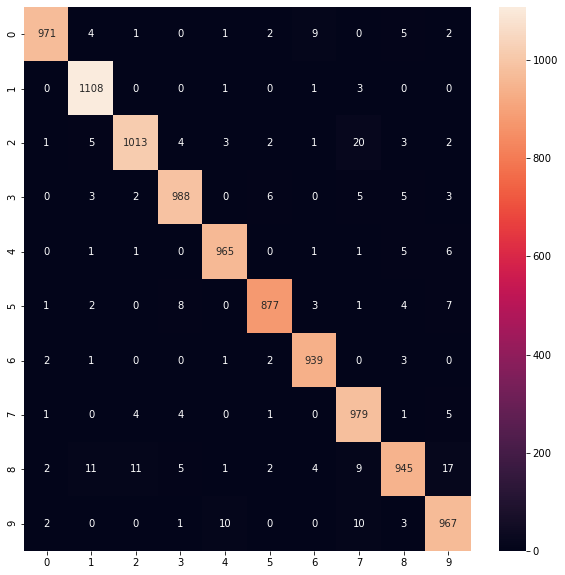

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       995
           1       0.98      1.00      0.99      1113
           2       0.98      0.96      0.97      1054
           3       0.98      0.98      0.98      1012
           4       0.98      0.98      0.98       980
           5       0.98      0.97      0.98       903
           6       0.98      0.99      0.99       948
           7       0.95      0.98      0.97       995
           8       0.97      0.94      0.95      1007
           9       0.96      0.97      0.97       993

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [133]:
# Performance Evaluation of Model 1
plt.figure(figsize=(10, 10))
cf_mat1 = confusion_matrix(y_test_pred1, y_test_labels)
sns.heatmap(cf_mat1, annot=True, fmt='g')
plt.show()
print(classification_report(y_test_pred1, y_test_labels))

### Training Model 2

In [42]:
# Train the model 2
history2 = model2.fit(train_dataset.shuffle(1024), epochs=1)

# Evaluate the model 2
results_train = model2.predict(train_dataset)
results_test = model2.predict(test_dataset)

# normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(results_train)
X_test = scaler.fit_transform(results_test)

# Apply kNN for classification k=11
knn2 = KNeighborsClassifier(n_neighbors=11)
knn2.fit(X_train, y_train_labels)
y_test_pred2 = knn2.predict(X_test)

ACC_test2 = np.mean(y_test_pred2 == y_test_labels)
print(f"ACC_test using Model 2 = {ACC_test2}")

1875/1875 [==============================] - 57s 30ms/step - loss: 0.2296
ACC_test using Model 2 = 0.985


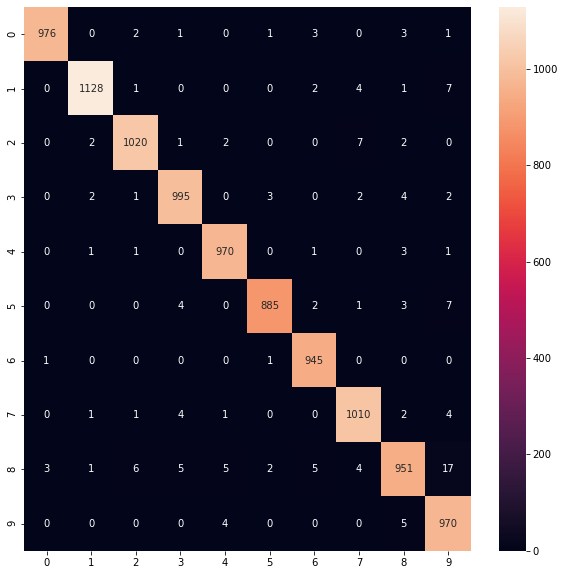

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       987
           1       0.99      0.99      0.99      1143
           2       0.99      0.99      0.99      1034
           3       0.99      0.99      0.99      1009
           4       0.99      0.99      0.99       977
           5       0.99      0.98      0.99       902
           6       0.99      1.00      0.99       947
           7       0.98      0.99      0.98      1023
           8       0.98      0.95      0.96       999
           9       0.96      0.99      0.98       979

    accuracy                           0.98     10000
   macro avg       0.98      0.99      0.98     10000
weighted avg       0.99      0.98      0.98     10000



In [43]:
# Performance Evaluation of Model 2
plt.figure(figsize=(10, 10))
cf_mat2 = confusion_matrix(y_test_pred2, y_test_labels)
sns.heatmap(cf_mat2, annot=True, fmt='g')
plt.show()
print(classification_report(y_test_pred2, y_test_labels))

Here we are going to compare Siamese Network without and with Gabor Filter. k-nearest neighbors algorithm will be used as final classifier based on **k = 11**. According to accuracy of test data, we got **0.9752** using Siamese Network without Gabor Filter and **0.985** using Siamese Network with Gabor Filter. As we can see that accuracy increases after combining Siamese Network with Gabor Filter. Something that we need to keep in mind while implementing Gabor Filter, we have to have some basic knowledge about its hyperparamters **Lambda, Theta, Psi, Sigma, and Gamma**. Because good result will depend on how we set the hyperparamters.